### **BASE MODEL**

### **상속을 통한 사용자 정의 지표 만들기**

In [20]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.metrics import Metric, AUC
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# 데이터
(train_data, train_labels), _ = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

train_data = vectorize_sequences(train_data)
# 일반화를 위한
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# 모델
model = keras.Sequential([
    layers.Input(shape=(10000,)),
    layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

In [21]:
class F1Score(Metric):
    def __init__(self, name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs) # 직접 명시 안하면 loss를 참조할 때, Metric의 설정을 참조하는 경향이 있음 -> train loss가 안 줄어듬
        self.true_positives = self.add_weight(name="tp", initializer="zeros")
        self.false_positives = self.add_weight(name="fp", initializer="zeros")
        self.false_negatives = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # float32로
        y_true = tf.cast(y_true, "float32")
        y_pred = tf.round(y_pred)
        y_pred = tf.cast(y_pred, "float32")

        # Confusion Matrix 각 요소 : label 0 or 1
        tp = tf.reduce_sum(tf.cast(y_true * y_pred, "float32")) # 타입 일치 ,텐서 합산
        fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, "float32"))
        fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), "float32"))

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)
    # Confusion Matrix 계산
    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1_score
    # 초기화
    def reset_states(self):
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)

In [22]:
# 모델 컴파일 시 사용자 정의 F1 스코어와 AUC 메트릭 추가
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy", F1Score(), AUC(name="auc")])

# 모델 학습
history = model.fit(
    train_data, train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.4
)

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5404 - auc: 0.5728 - f1_score: 0.6175 - loss: 0.7806 - val_accuracy: 0.7658 - val_auc: 0.8488 - val_f1_score: 0.5452 - val_loss: 0.7245
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7064 - auc: 0.7962 - f1_score: 0.5611 - loss: 0.7064 - val_accuracy: 0.8380 - val_auc: 0.9093 - val_f1_score: 0.5094 - val_loss: 0.6164
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7987 - auc: 0.8747 - f1_score: 0.5208 - loss: 0.6100 - val_accuracy: 0.8552 - val_auc: 0.9287 - val_f1_score: 0.5204 - val_loss: 0.5274
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8310 - auc: 0.9051 - f1_score: 0.5180 - loss: 0.5354 - val_accuracy: 0.8697 - val_auc: 0.9369 - val_f1_score: 0.4998 - val_loss: 0.4650
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8541 - auc: 0.9250 - f1_score: 0.5093 - loss: 0.4739 - val_accuracy: 0.8737 - val_auc: 0.9424 - val_f1_score: 0.4922 - va

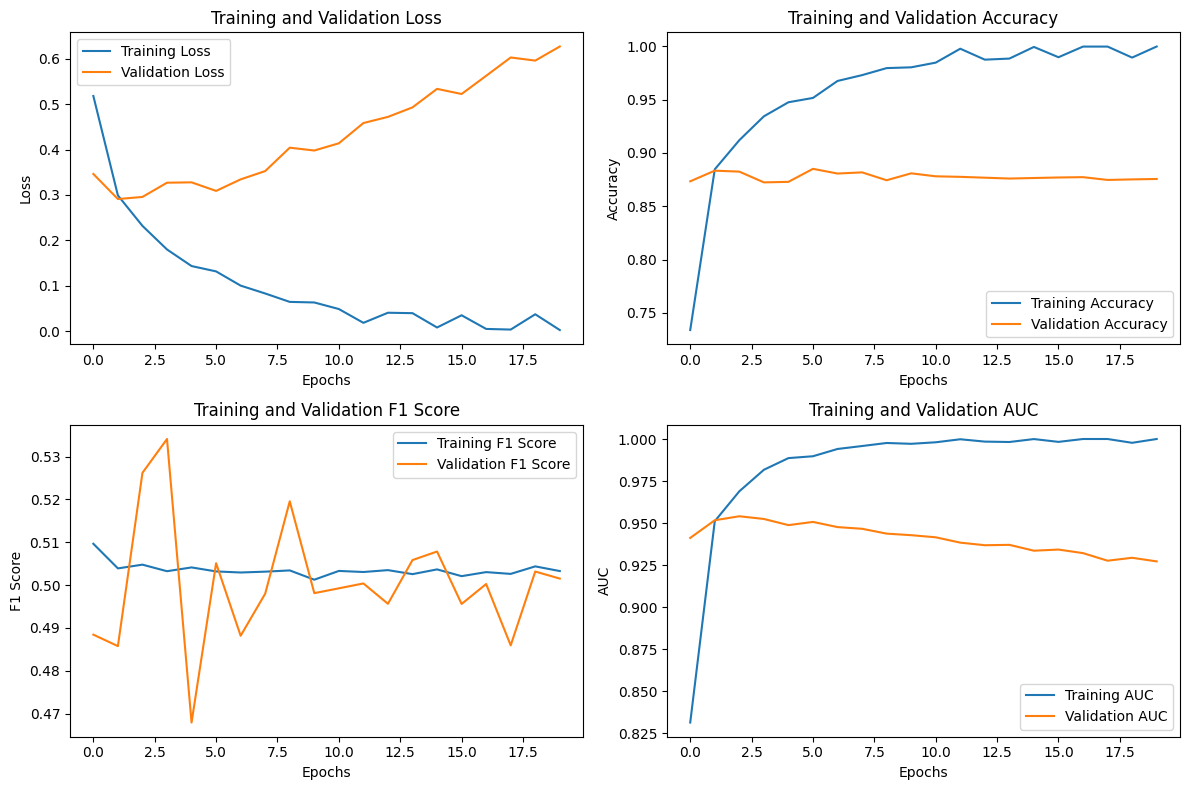

In [18]:
# 학습 과정 시각화 함수 정의
def plot_metrics(history):
    # 손실(Loss) 시각화
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # 정확도(Accuracy) 시각화
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # F1 Score 시각화
    if 'f1_score' in history.history:
        plt.subplot(2, 2, 3)
        plt.plot(history.history['f1_score'], label='Training F1 Score')
        plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.title('Training and Validation F1 Score')
        plt.legend()

    # AUC 시각화
    if 'auc' in history.history:
        plt.subplot(2, 2, 4)
        plt.plot(history.history['auc'], label='Training AUC')
        plt.plot(history.history['val_auc'], label='Validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.title('Training and Validation AUC')
        plt.legend()

    plt.tight_layout()
    plt.show()

# 시각화 함수 호출
plot_metrics(history)

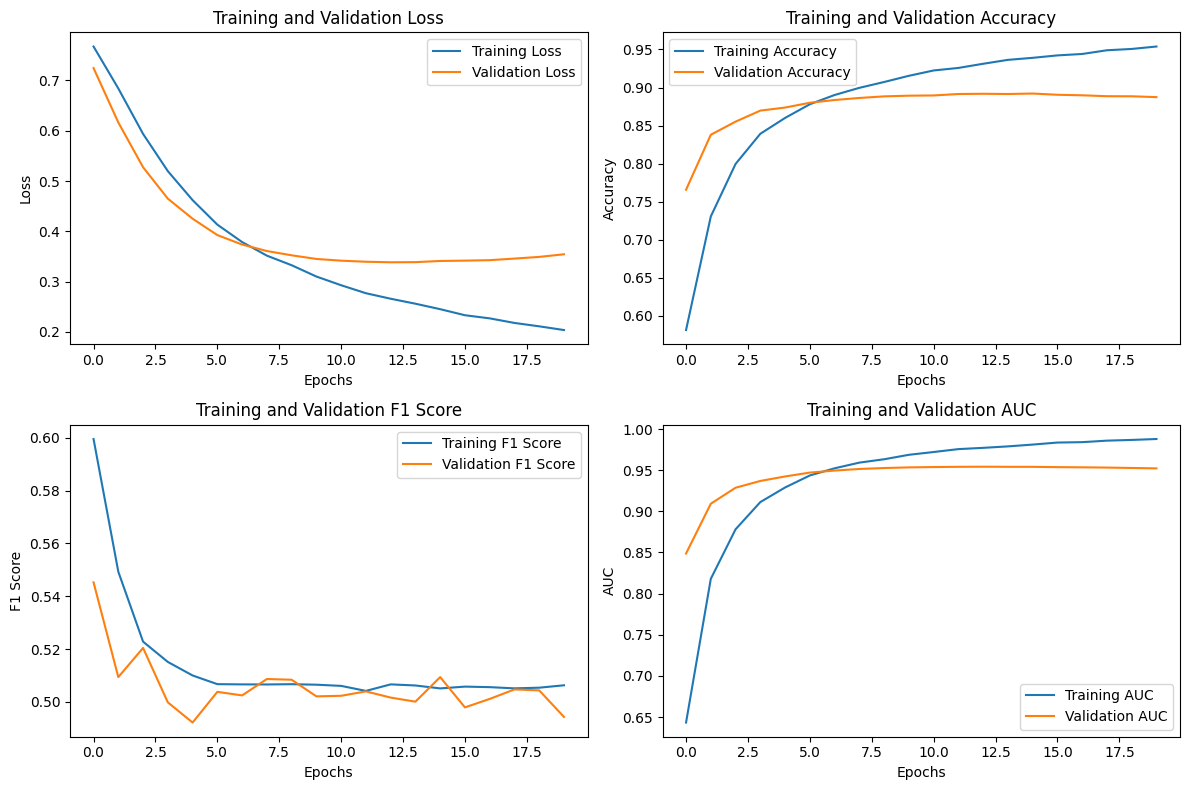

In [23]:
plot_metrics(history)